# Task 2: GraphSLAM Evaluation

## A. Incremental Solution

At each time iteration, solve the graphSlam problem. Monitor the current error in the graph at each iteration by using the function graph.chi2(). This function re-evaluates all residuals and calculates the current error. Plot in a graphic its result w.r.t time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mrob
from tqdm import tqdm

from tools.objects import Gaussian
from tools.data import load_data
from slam.graphSlam import GraphSLAM

### Load and init

In [2]:
data_file = 'slam-evaluation-input.npy'
data = load_data(data_file)

alphas = np.array([0.05, 0.001, 0.05, 0.01]) ** 2
beta = np.array([10.0, 10.0])
beta[1] = np.deg2rad(beta[1])

mean_prior = np.array([180., 50., 0.])
Sigma_prior = 1e-12 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)

slam_solver = GraphSLAM(
    initial_state=initial_state,
    alphas=alphas,
    slam_type='graphSlam',
    data_association='known',
    update_type='batch',
    Q=np.diag([beta[0]**2, beta[1]**2]),
    verbose=False
)

### Data handling and calculating $\chi^2$

In [3]:
chi2_errors = []
time_steps = []

print("Processing data...")
for t in tqdm(range(data.num_steps)):
    u = data.filter.motion_commands[t]
    z = data.filter.observations[t]
    
    slam_solver.predict(u)
    slam_solver.update(z)
    
    slam_solver.solve()
    
    chi2_error = slam_solver.graph.chi2()
    
    chi2_errors.append(chi2_error)
    time_steps.append(t)

Processing data...


100%|██████████| 110/110 [00:00<00:00, 1970.97it/s]


### Plotting

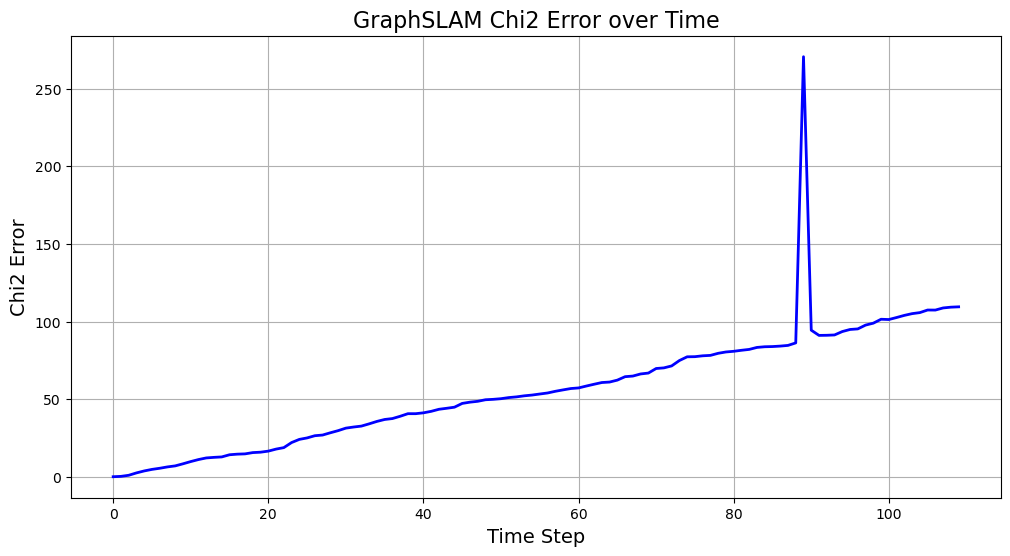

Final Chi2 Error: 109.47927098012555


In [4]:
plt.figure(figsize=(12, 6))
plt.plot(time_steps, chi2_errors, 'b-', linewidth=2)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Chi2 Error', fontsize=14)
plt.title('GraphSLAM Chi2 Error over Time', fontsize=16)
plt.grid(True)
plt.savefig('graphslam_chi2_error.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Final Chi2 Error: {chi2_errors[-1]}")

### Analyze

In [5]:
mean_error = np.mean(chi2_errors)
max_error = np.max(chi2_errors)
min_error = np.min(chi2_errors)
std_error = np.std(chi2_errors)

print(f"chi2 Statistics:")
print(f"Mean error: {mean_error:.2f}")
print(f"Max error: {max_error:.2f}")
print(f"Min error: {min_error:.2f}")
print(f"Std error: {std_error:.2f}")

chi2 Statistics:
Mean error: 56.09
Max error: 270.65
Min error: 0.00
Std error: 38.06


### B. Trajectory and map

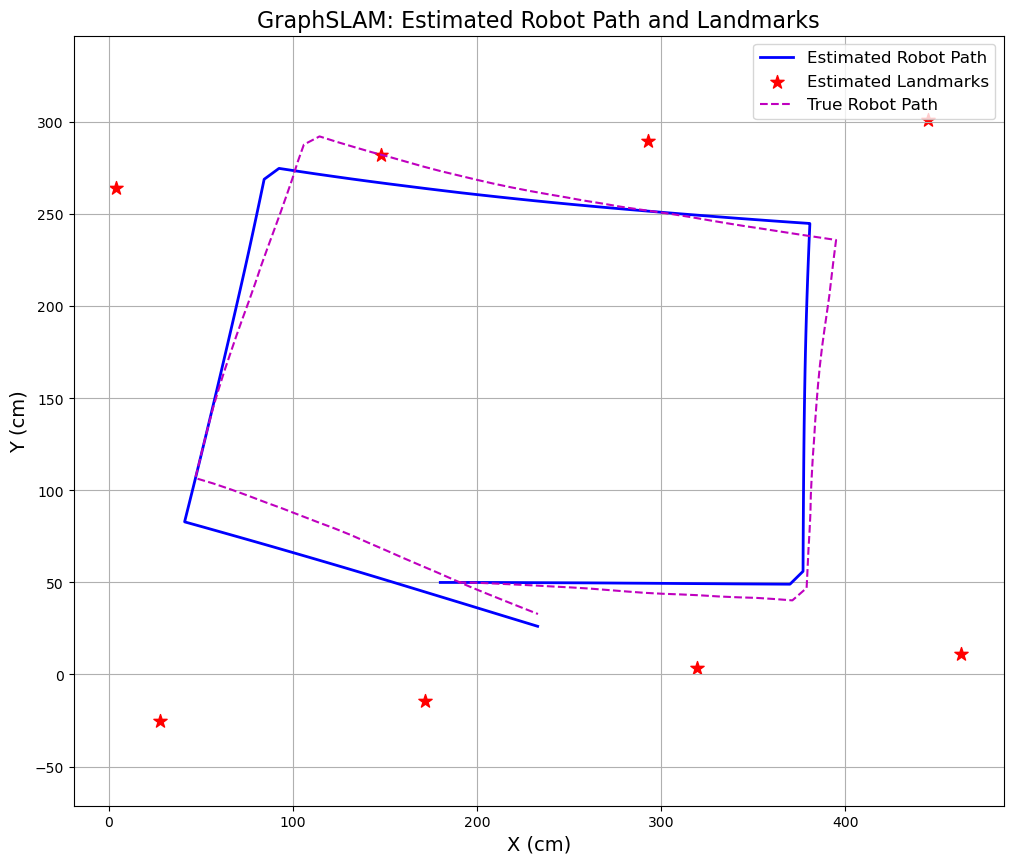

In [6]:
final_state = slam_solver.graph.get_estimated_state()

robot_poses = []
landmarks = []

for i, state in enumerate(final_state):
    if state.shape[0] == 3:  # Поза робота (x, y, theta)
        robot_poses.append(state.flatten())
    elif state.shape[0] == 2:  # Ориентир (x, y)
        landmarks.append(state.flatten())

robot_poses = np.array(robot_poses)
landmarks = np.array(landmarks)

plt.figure(figsize=(12, 10))
plt.plot(robot_poses[:, 0], robot_poses[:, 1], 'b-', linewidth=2, label='Estimated Robot Path')
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=100, marker='*', label='Estimated Landmarks')

plt.plot(data.debug.real_robot_path[:, 0], data.debug.real_robot_path[:, 1], 'm--', linewidth=1.5, label='True Robot Path')

plt.xlabel('X (cm)', fontsize=14)
plt.ylabel('Y (cm)', fontsize=14)
plt.title('GraphSLAM: Estimated Robot Path and Landmarks', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.savefig('graphslam_map.png', dpi=300, bbox_inches='tight')
plt.show()

### C. Adjacency matrix

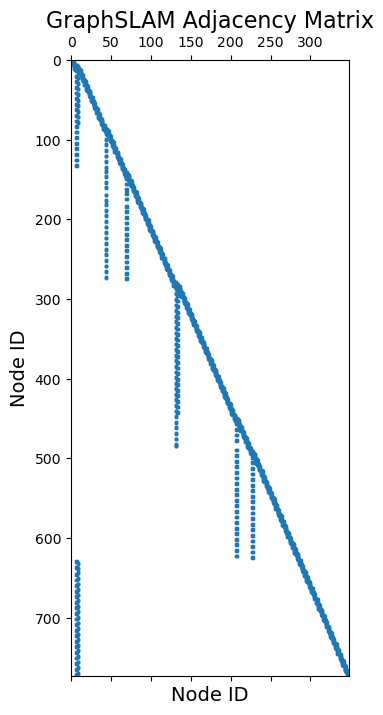

In [7]:
adjacency_matrix = slam_solver.graph.get_adjacency_matrix()

plt.figure(figsize=(4, 8))
plt.spy(adjacency_matrix, markersize=2)
plt.title('GraphSLAM Adjacency Matrix', fontsize=16)
plt.xlabel('Node ID', fontsize=14)
plt.ylabel('Node ID', fontsize=14)
plt.savefig('graphslam_adjacency_matrix.png', bbox_inches='tight')
plt.show()

In [8]:
print(f"Adjacency Matrix Shape: {adjacency_matrix.shape}")
print(f"Number of non-zero elements: {adjacency_matrix.count_nonzero()}")
print(f"Sparsity: {adjacency_matrix.count_nonzero() / (adjacency_matrix.shape[0] * adjacency_matrix.shape[1]):.4f}")

Adjacency Matrix Shape: (773, 349)
Number of non-zero elements: 2863
Sparsity: 0.0106


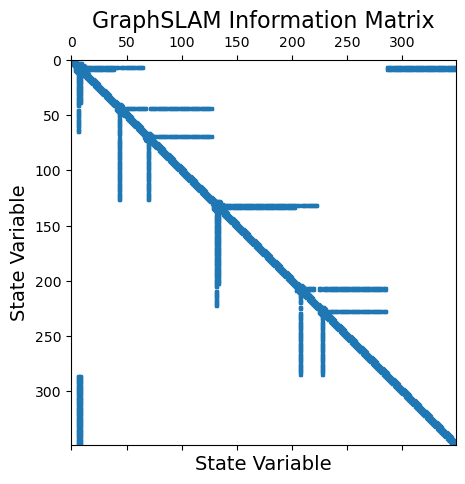

In [9]:
information_matrix = slam_solver.graph.get_information_matrix()
plt.figure(figsize=(5, 5))
plt.spy(information_matrix, markersize=2)
plt.title('GraphSLAM Information Matrix', fontsize=16)
plt.xlabel('State Variable', fontsize=14)
plt.ylabel('State Variable', fontsize=14)
plt.savefig('graphslam_information_matrix.png', bbox_inches='tight')
plt.show()

In [10]:
print("\nInformation Matrix:")
print(f"Shape: {information_matrix.shape}")
print(f"Number of non-zero elements: {information_matrix.count_nonzero()}")
print(f"Sparsity: {information_matrix.count_nonzero() / (information_matrix.shape[0] * information_matrix.shape[1]):.4f}")


Information Matrix:
Shape: (349, 349)
Number of non-zero elements: 4757
Sparsity: 0.0391


Comments on the structure:

Looking at the structure of these matrices, we can see that the adjacency matrix reveals how nodes are connected in the graph. When we see a non-zero element, it tells us there's a constraint linking two nodes together. Along the diagonal, we find self-connections for each node. What's interesting is how sparse these matrices are - most nodes only connect to a small number of other nodes rather than forming a densely connected network. While the adjacency matrix shows us the connectivity pattern, the information matrix builds on this by providing the actual numerical constraint values. We can also observe a clear block structure in the information matrix that corresponds to how the different variables - both robot poses and landmarks - are organized. The information matrix exhibits what's known as an "arrow-head" structure - this distinctive pattern emerges from the way robot poses are connected sequentially along the trajectory while landmarks create connections between temporally distant poses, forming arrow-like patterns in the matrix.

### D. Covariance

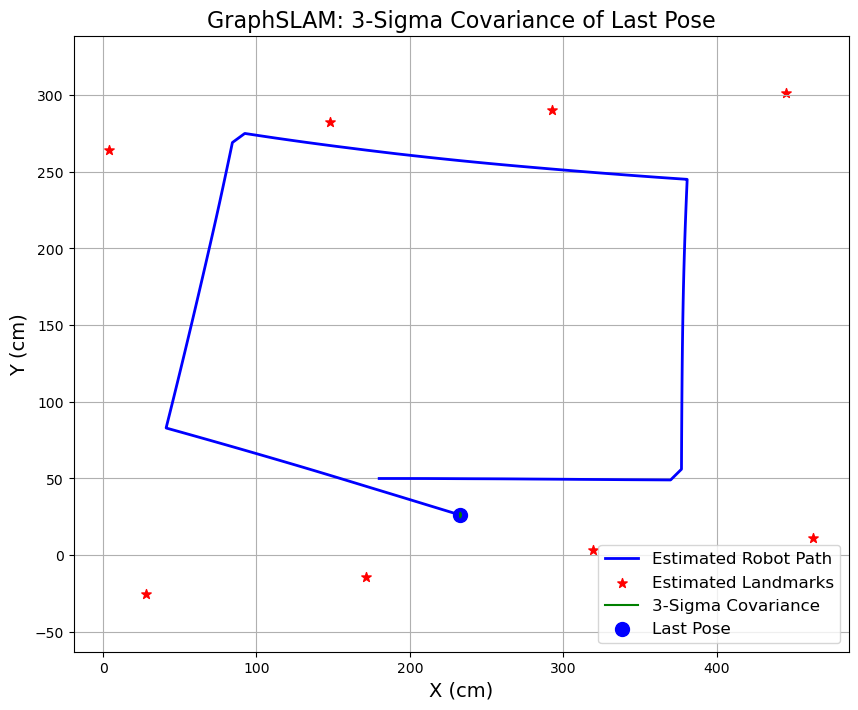

In [11]:
from tools.plot import plot2dcov
import numpy as np
from scipy.linalg import cholesky

last_pose = robot_poses[-1]
last_position = last_pose[0:2]

information_matrix = slam_solver.graph.get_information_matrix()
total_state_dim = information_matrix.shape[0]

last_pose_start_idx = total_state_dim - 3
position_indices = slice(last_pose_start_idx, last_pose_start_idx + 2)

position_information = information_matrix[position_indices, position_indices].toarray()

try:
    position_covariance = np.linalg.inv(position_information)
except np.linalg.LinAlgError:
    # Handle singular matrix
    print("Warning: Information matrix is singular. Using pseudoinverse.")
    position_covariance = np.linalg.pinv(position_information)

plt.figure(figsize=(10, 8))
plt.plot(robot_poses[:, 0], robot_poses[:, 1], 'b-', linewidth=2, label='Estimated Robot Path')
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='r', s=50, marker='*', label='Estimated Landmarks')

plot2dcov(last_position, position_covariance, 'green', 3, legend='3-Sigma Covariance')
plt.scatter(last_position[0], last_position[1], c='blue', s=100, marker='o', label='Last Pose')

plt.xlabel('X (cm)', fontsize=14)
plt.ylabel('Y (cm)', fontsize=14)
plt.title('GraphSLAM: 3-Sigma Covariance of Last Pose', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.savefig('graphslam_covariance.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
print("Covariance of the last pose:")
print(f"Position covariance matrix:\n{position_covariance}")
print(f"Determinant: {np.linalg.det(position_covariance):.6f}")
print(f"Trace: {np.trace(position_covariance):.6f}")

eigenvalues, eigenvectors = np.linalg.eig(position_covariance)
print("\nEigenvalues of the position covariance:")
print(eigenvalues)
print("\nEigenvectors of the position covariance:")
print(eigenvectors)

major_axis = np.sqrt(eigenvalues[0]) * 3
minor_axis = np.sqrt(eigenvalues[1]) * 3
angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])

print("\nUncertainty ellipse parameters (3-sigma):")
print(f"Major axis: {major_axis:.4f} cm")
print(f"Minor axis: {minor_axis:.4f} cm")
print(f"Orientation angle: {np.rad2deg(angle):.2f} degrees")

Covariance of the last pose:
Position covariance matrix:
[[9.99998041e-05 5.07555980e-08]
 [5.07555980e-08 2.49680245e-01]]
Determinant: 0.000025
Trace: 0.249780

Eigenvalues of the position covariance:
[9.99998041e-05 2.49680245e-01]

Eigenvectors of the position covariance:
[[-1.00000000e+00 -2.03363844e-07]
 [ 2.03363844e-07 -1.00000000e+00]]

Uncertainty ellipse parameters (3-sigma):
Major axis: 0.0300 cm
Minor axis: 1.4990 cm
Orientation angle: 180.00 degrees


### E. Batch solution

In [14]:
# Reset the SLAM solver to start fresh
mean_prior = np.array([180., 50., 0.])
Sigma_prior = 1e-12 * np.eye(3, 3)
initial_state = Gaussian(mean_prior, Sigma_prior)

batch_slam_solver = GraphSLAM(
    initial_state=initial_state,
    alphas=alphas,
    slam_type='graphSlam',
    data_association='known',
    update_type='batch',  # Using batch update
    Q=np.diag([beta[0]**2, beta[1]**2]),
    verbose=False
)

# Process all data without solving at each step
print("Processing data for batch solution...")
for t in tqdm(range(data.num_steps)):
    u = data.filter.motion_commands[t]
    z = data.filter.observations[t]
    
    batch_slam_solver.predict(u)
    batch_slam_solver.update(z)
    # without solve()

# Now solve
print("\nSolving with Gauss-Newton (GN)...")
iterations_gn = 0
chi2_errors_gn = []

# Initial chi2 error before optimization
initial_chi2 = batch_slam_solver.graph.chi2()
chi2_errors_gn.append(initial_chi2)
print(f"Initial Chi2 Error: {initial_chi2}")

Processing data for batch solution...


100%|██████████| 110/110 [00:00<00:00, 13194.16it/s]


Solving with Gauss-Newton (GN)...
Initial Chi2 Error: 755.5162500452889


In [15]:
# Solve with Gauss-Newton until convergence
max_iterations = 20
convergence_threshold = 1e-6
prev_chi2 = initial_chi2

for i in range(max_iterations):
    batch_slam_solver.graph.solve(mrob.GN)
    iterations_gn += 1
    
    current_chi2 = batch_slam_solver.graph.chi2()
    chi2_errors_gn.append(current_chi2)
    
    chi2_change = abs(prev_chi2 - current_chi2)
    print(f"Iteration {i+1}, Chi2: {current_chi2}, Change: {chi2_change}")
    
    if chi2_change < convergence_threshold:
        print(f"Converged after {iterations_gn} iterations")
        break
    
    prev_chi2 = current_chi2

final_chi2_gn = batch_slam_solver.graph.chi2()

Iteration 1, Chi2: 15155.10457838449, Change: 14399.5883283392
Iteration 2, Chi2: 134.97852338000905, Change: 15020.12605500448
Iteration 3, Chi2: 109.47091814749739, Change: 25.507605232511665
Iteration 4, Chi2: 109.46950910653095, Change: 0.0014090409664362369
Iteration 5, Chi2: 109.46901337538645, Change: 0.0004957311444968582
Iteration 6, Chi2: 109.46901340044715, Change: 2.506070018171158e-08
Converged after 6 iterations


In [20]:
# Now with Levenberg-Marquardt
print("\nSolving with Levenberg-Marquardt (LM)...")
# Reset the solver to start fresh
batch_slam_solver_lm = GraphSLAM(
    initial_state=initial_state,
    alphas=alphas,
    slam_type='graphSlam',
    data_association='known',
    update_type='batch',
    Q=np.diag([beta[0]**2, beta[1]**2]),
    verbose=False
)

# Process all data without solving
for t in tqdm(range(data.num_steps)):
    u = data.filter.motion_commands[t]
    z = data.filter.observations[t]
    
    batch_slam_solver_lm.predict(u)
    batch_slam_solver_lm.update(z)

# Initial chi2 error before optimization
initial_chi2_lm = batch_slam_solver_lm.graph.chi2()
print(f"Initial Chi2 Error: {initial_chi2_lm}")

# Solve
batch_slam_solver_lm.graph.solve(mrob.LM)
final_chi2_lm = batch_slam_solver_lm.graph.chi2()
final_chi2_lm
### very bad ???


Solving with Levenberg-Marquardt (LM)...


100%|██████████| 110/110 [00:00<00:00, 15501.58it/s]

Initial Chi2 Error: 755.5162500452889


109.84588042571096

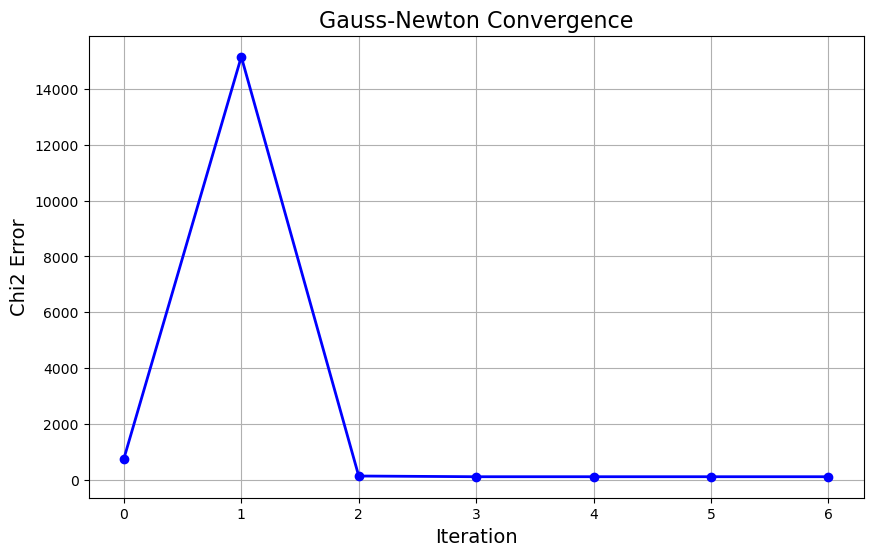


Batch Solution Summary:
Gauss-Newton:
  - Iterations required: 6
  - Final Chi2 Error: 109.46901340044715
Levenberg-Marquardt:
  - Final Chi2 Error: 109.84588042571096


In [21]:
# Plot the convergence of GN
plt.figure(figsize=(10, 6))
plt.plot(range(len(chi2_errors_gn)), chi2_errors_gn, 'b-o', linewidth=2)
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('Chi2 Error', fontsize=14)
plt.title('Gauss-Newton Convergence', fontsize=16)
plt.grid(True)
plt.savefig('graphslam_gn_convergence.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\nBatch Solution Summary:")
print(f"Gauss-Newton:")
print(f"  - Iterations required: {iterations_gn}")
print(f"  - Final Chi2 Error: {final_chi2_gn}")
print(f"Levenberg-Marquardt:")
print(f"  - Final Chi2 Error: {final_chi2_lm}")

In [22]:
# Compare final states
final_state_gn = batch_slam_solver.graph.get_estimated_state()
final_state_lm = batch_slam_solver_lm.graph.get_estimated_state()

# Extract robot poses and landmarks for GN
robot_poses_gn = []
landmarks_gn = []

for i, state in enumerate(final_state_gn):
    if state.shape[0] == 3:  # Robot pose (x, y, theta)
        robot_poses_gn.append(state.flatten())
    elif state.shape[0] == 2:  # Landmark (x, y)
        landmarks_gn.append(state.flatten())

robot_poses_gn = np.array(robot_poses_gn)
landmarks_gn = np.array(landmarks_gn)

# Extract robot poses and landmarks for LM
robot_poses_lm = []
landmarks_lm = []

for i, state in enumerate(final_state_lm):
    if state.shape[0] == 3:  # Robot pose (x, y, theta)
        robot_poses_lm.append(state.flatten())
    elif state.shape[0] == 2:  # Landmark (x, y)
        landmarks_lm.append(state.flatten())

robot_poses_lm = np.array(robot_poses_lm)
landmarks_lm = np.array(landmarks_lm)

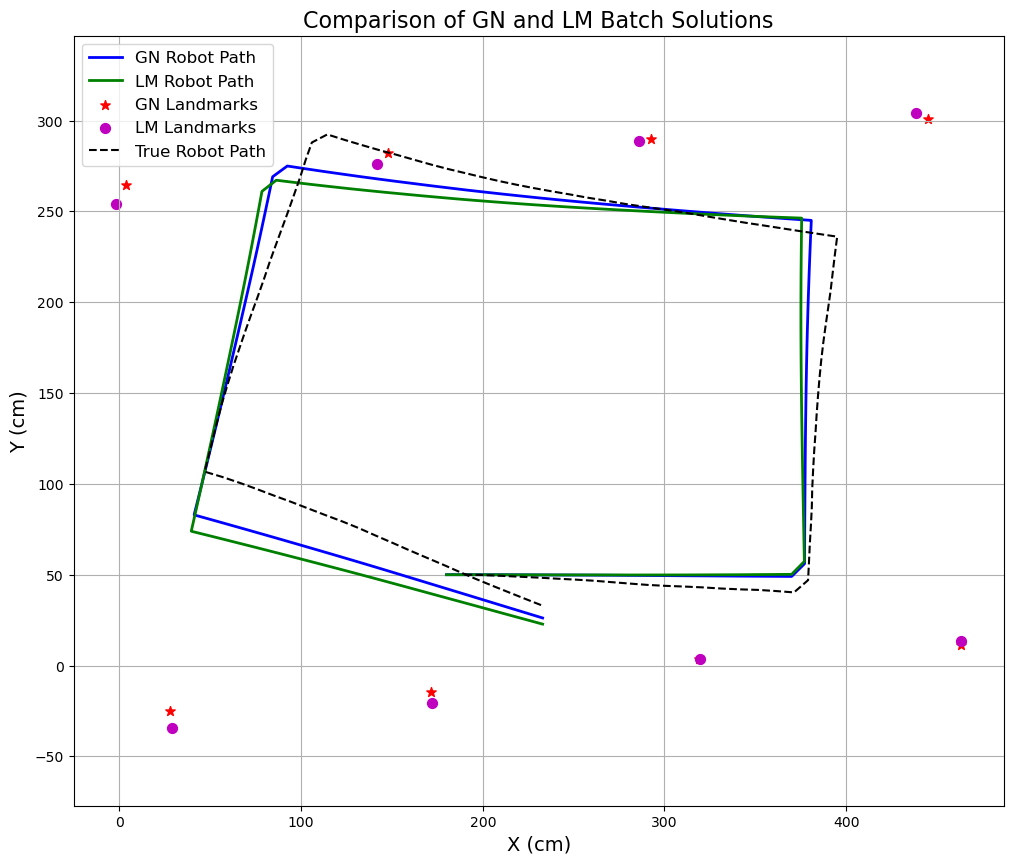

In [23]:
# Plot comparison
plt.figure(figsize=(12, 10))
plt.plot(robot_poses_gn[:, 0], robot_poses_gn[:, 1], 'b-', linewidth=2, label='GN Robot Path')
plt.plot(robot_poses_lm[:, 0], robot_poses_lm[:, 1], 'g-', linewidth=2, label='LM Robot Path')
plt.scatter(landmarks_gn[:, 0], landmarks_gn[:, 1], c='r', s=50, marker='*', label='GN Landmarks')
plt.scatter(landmarks_lm[:, 0], landmarks_lm[:, 1], c='m', s=50, marker='o', label='LM Landmarks')
plt.plot(data.debug.real_robot_path[:, 0], data.debug.real_robot_path[:, 1], 'k--', linewidth=1.5, label='True Robot Path')

plt.xlabel('X (cm)', fontsize=14)
plt.ylabel('Y (cm)', fontsize=14)
plt.title('Comparison of GN and LM Batch Solutions', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.axis('equal')
plt.savefig('graphslam_batch_comparison.png', dpi=300, bbox_inches='tight')
plt.show()